In [ ]:
pip install transformers torch

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, ParameterGrid
from transformers import BertTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
from sklearn.exceptions import UndefinedMetricWarning
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

# Skenario 1

Mounted at /content/drive
Label distribution in the dataset:
label
Openness             90
Agreeableness        71
Neuroticsm           45
Conscientiousness    17
Extroversion          7
Name: count, dtype: int64


<ipython-input-3-9a917322f4f1>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=label_distribution.index, y=label_distribution.values, palette='pastel')


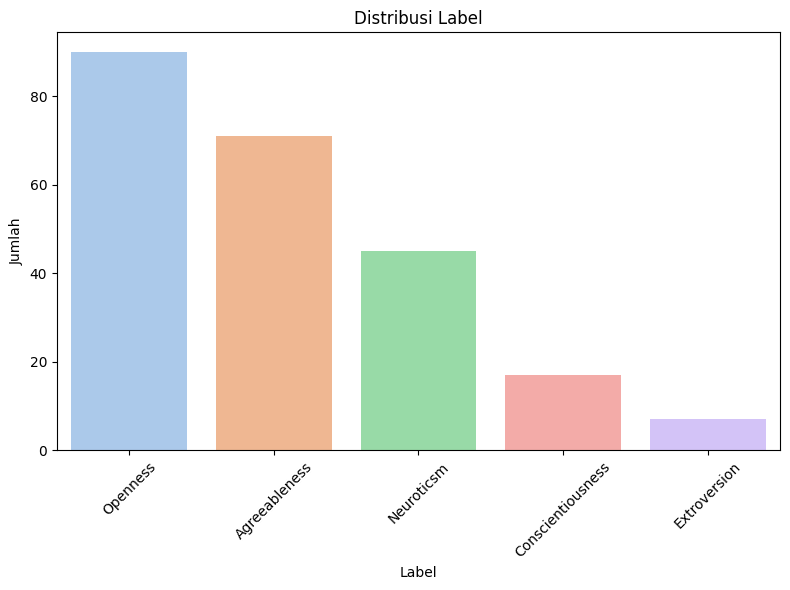

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
file_path = '/content/drive/My Drive/Dataset TA/skenario_1_final.csv'
data = pd.read_csv(file_path)

data.head()

# Hitung distribusi label
label_distribution = data['label'].value_counts()

# Print label distribution
print("Label distribution in the dataset:")
print(label_distribution)

# Visualisasi distribusi data dalam bentuk bar chart
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x=label_distribution.index, y=label_distribution.values, palette='pastel')
plt.title("Distribusi Label")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Create a label mapping
label_mapping = {label: idx for idx, label in enumerate(data['label'].unique())}
data['label'] = data['label'].map(label_mapping)  # Convert string labels to integers

# Verify the label conversion
print("Label mapping:")
print(label_mapping)
print("Converted label distribution:")
print(data['label'].value_counts())

Label mapping:
{'Neuroticsm': 0, 'Agreeableness': 1, 'Openness': 2, 'Conscientiousness': 3, 'Extroversion': 4}
Converted label distribution:
label
2    90
1    71
0    45
3    17
4     7
Name: count, dtype: int64



Training data size: 184
Testing data size: 46
Training label distribution:
label
2    72
1    57
0    36
3    14
4     5
Name: count, dtype: int64

Testing label distribution:
label
2    18
1    14
0     9
3     3
4     2
Name: count, dtype: int64


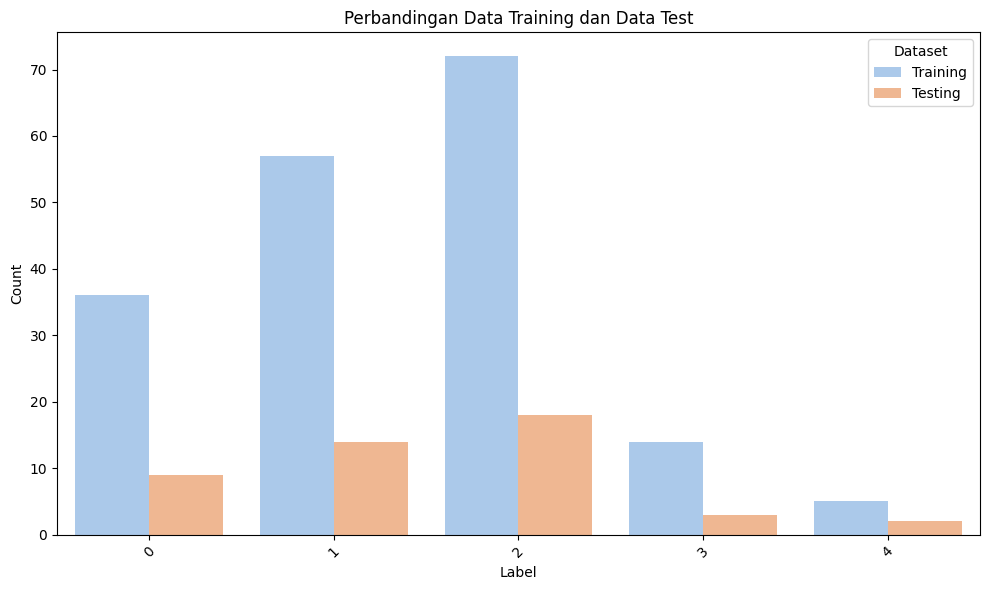

In [ ]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])

# Display the sizes of the training and testing sets
print(f"\nTraining data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")

# Check the distribution of labels in both sets
train_label_distribution = train_data['label'].value_counts()
test_label_distribution = test_data['label'].value_counts()

print("Training label distribution:")
print(train_label_distribution)
print("\nTesting label distribution:")
print(test_label_distribution)

# Prepare data for visualization
label_names = train_label_distribution.index.union(test_label_distribution.index)
train_counts = train_label_distribution.reindex(label_names, fill_value=0)
test_counts = test_label_distribution.reindex(label_names, fill_value=0)

# Create a DataFrame for plotting
comparison_df = pd.DataFrame({
    'Label': label_names,
    'Training': train_counts.values,
    'Testing': test_counts.values
})

# Melt the DataFrame for easier plotting
comparison_df = comparison_df.melt(id_vars='Label', var_name='Dataset', value_name='Count')

# Create the bar plot
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Label', y='Count', hue='Dataset', data=comparison_df, palette='pastel')

# Set title and labels
plt.title("Perbandingan Data Training dan Data Test")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

In [ ]:
# Load the tokenizer for IndoBERT
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

# Prepare text data for tokenization
train_texts = train_data['processed_text'].tolist()
test_texts = test_data['processed_text'].tolist()

# Tokenization for IndoBERT
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

# Print the number of tokenized samples
print(f"Jumlah data latih IndoBERT: {len(train_encodings['input_ids'])}")
print(f"Jumlah data uji IndoBERT: {len(test_encodings['input_ids'])}")

# Display examples of tokenized data
print(f"\nContoh data latih :")
print(f"Teks Asli: {train_texts[1]}")
print(f"Token IDs: {train_encodings['input_ids'][1]}")
print(f"Attention Mask: {train_encodings['attention_mask'][1]}")

# Convert token IDs back to tokens
tokens = tokenizer.convert_ids_to_tokens(train_encodings['input_ids'][1])
print(f"Tokens: {tokens}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Jumlah data latih IndoBERT: 184
Jumlah data uji IndoBERT: 46

Contoh data latih :
Teks Asli: relationship status ginigini butuh ruqiah aura muncul nggon nyaman enzy tertawa tertawa mengakak nomor induk siswa hesty nomor induk siswa gek dadi mbangane marai gemas petuah lari pagi have created fabulous hidup berkompetisi jalan masingmasing memaksa diburuburu semangat awokwokwok asam wee perbarui media sosial balas chat perbarui media sosial balas chat berbeda menamparmu siangsiang langkah gerakan lamban selamat malam nasi goreng sumsum ceplok mudah membuatnya fast alone far together cakap iklan kompak pawcious smile tofucorgi instagram ngalami masak ngalami sebegitunya pesan sw suaminya kakak domisili bekasi jasa semoga ayah lancarkan usaha after hearing hurtful trying henti cry soulmate friendships indeed real apa-apa apa-apa apa-apa diskualifikasi menikah notes person who being alone powerful person mengeluh dikerjain sikap profesional menjalani hidup friendly reminder rungokno ibumu ye

In [ ]:
# Create the TweetDataset class
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])  # This should now be an integer
        return item

# Create datasets
train_dataset = TweetDataset(train_encodings, train_data['label'].tolist())
test_dataset = TweetDataset(test_encodings, test_data['label'].tolist())

Parameters: {'batch_size': 8, 'learning_rate': 2e-05}


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-178feda399ac>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.832600,1.423786,0.391304,0.153119,0.391304,0.220109
2,1.832600,1.414890,0.304348,0.092628,0.304348,0.142029
3,1.832600,1.385498,0.391304,0.153119,0.391304,0.220109
4,1.832600,1.383704,0.391304,0.153119,0.391304,0.220109
5,1.354800,1.421503,0.369565,0.257023,0.369565,0.303185
6,1.354800,1.446045,0.326087,0.247826,0.326087,0.266798
7,1.354800,1.565037,0.391304,0.231396,0.391304,0.290277
8,1.354800,1.769908,0.369565,0.316770,0.369565,0.333863
9,0.962700,1.765914,0.391304,0.321182,0.391304,0.346337
10,0.962700,1.846755,0.391304,0.323889,0.391304,0.344831


Accuracy: 0.41304347826086957
F1 Score: 0.37601112234580386

Classification Report for Params: {'batch_size': 8, 'learning_rate': 2e-05}
                   precision    recall  f1-score   support

       Neuroticsm     0.2857    0.2222    0.2500         9
    Agreeableness     0.3571    0.3571    0.3571        14
         Openness     0.4800    0.6667    0.5581        18
Conscientiousness     0.0000    0.0000    0.0000         3
     Extroversion     0.0000    0.0000    0.0000         2

         accuracy                         0.4130        46
        macro avg     0.2246    0.2492    0.2331        46
     weighted avg     0.3524    0.4130    0.3760        46

Parameters: {'batch_size': 8, 'learning_rate': 3e-05}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-178feda399ac>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.594000,1.376688,0.391304,0.153119,0.391304,0.220109
2,1.594000,1.400157,0.304348,0.092628,0.304348,0.142029
3,1.594000,1.371699,0.391304,0.153119,0.391304,0.220109
4,1.594000,1.389351,0.391304,0.153119,0.391304,0.220109
5,1.372900,1.410305,0.478261,0.327718,0.478261,0.387216
6,1.372900,1.438593,0.565217,0.494774,0.565217,0.509608
7,1.372900,1.505552,0.456522,0.356438,0.456522,0.400318
8,1.372900,1.879943,0.304348,0.253913,0.304348,0.267153
9,0.844700,1.943325,0.434783,0.386749,0.434783,0.394129
10,0.844700,2.070351,0.434783,0.366522,0.434783,0.388442


Accuracy: 0.5652173913043478
F1 Score: 0.5096077835208269

Classification Report for Params: {'batch_size': 8, 'learning_rate': 3e-05}
                   precision    recall  f1-score   support

       Neuroticsm     0.5000    0.2222    0.3077         9
    Agreeableness     0.5625    0.6429    0.6000        14
         Openness     0.5769    0.8333    0.6818        18
Conscientiousness     0.0000    0.0000    0.0000         3
     Extroversion     0.0000    0.0000    0.0000         2

         accuracy                         0.5652        46
        macro avg     0.3279    0.3397    0.3179        46
     weighted avg     0.4948    0.5652    0.5096        46

Parameters: {'batch_size': 8, 'learning_rate': 4e-05}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-178feda399ac>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.594000,1.374087,0.391304,0.153119,0.391304,0.220109
2,1.594000,1.407163,0.304348,0.092628,0.304348,0.142029
3,1.594000,1.383301,0.391304,0.153119,0.391304,0.220109
4,1.594000,1.418032,0.304348,0.236099,0.304348,0.245320
5,1.381800,1.438975,0.304348,0.237578,0.304348,0.252717
6,1.381800,1.571366,0.369565,0.259881,0.369565,0.304693
7,1.381800,2.114583,0.347826,0.216965,0.347826,0.266555
8,1.381800,2.202980,0.260870,0.239493,0.260870,0.245304
9,0.637700,2.683364,0.434783,0.421196,0.434783,0.388696
10,0.637700,2.868731,0.391304,0.418478,0.391304,0.385332


Accuracy: 0.45652173913043476
F1 Score: 0.4044795783926219

Classification Report for Params: {'batch_size': 8, 'learning_rate': 4e-05}
                   precision    recall  f1-score   support

       Neuroticsm     1.0000    0.2222    0.3636         9
    Agreeableness     0.5714    0.2857    0.3810        14
         Openness     0.4167    0.8333    0.5556        18
Conscientiousness     0.0000    0.0000    0.0000         3
     Extroversion     0.0000    0.0000    0.0000         2

         accuracy                         0.4565        46
        macro avg     0.3976    0.2683    0.2600        46
     weighted avg     0.5326    0.4565    0.4045        46

Parameters: {'batch_size': 8, 'learning_rate': 5e-05}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-178feda399ac>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.594000,1.370892,0.391304,0.153119,0.391304,0.220109
2,1.594000,1.414360,0.304348,0.092628,0.304348,0.142029
3,1.594000,1.384999,0.391304,0.153119,0.391304,0.220109
4,1.594000,1.370277,0.391304,0.153119,0.391304,0.220109
5,1.392800,1.403851,0.304348,0.092628,0.304348,0.142029
6,1.392800,1.513194,0.391304,0.262876,0.391304,0.314229
7,1.392800,1.421044,0.500000,0.567780,0.500000,0.427496
8,1.392800,1.896325,0.413043,0.443478,0.413043,0.366037
9,0.964300,2.208064,0.326087,0.235043,0.326087,0.272974
10,0.964300,2.242812,0.434783,0.320101,0.434783,0.368187


Accuracy: 0.5
F1 Score: 0.4274960189161801

Classification Report for Params: {'batch_size': 8, 'learning_rate': 5e-05}
                   precision    recall  f1-score   support

       Neuroticsm     0.3750    0.3333    0.3529         9
    Agreeableness     1.0000    0.2143    0.3529        14
         Openness     0.4857    0.9444    0.6415        18
Conscientiousness     0.0000    0.0000    0.0000         3
     Extroversion     0.0000    0.0000    0.0000         2

         accuracy                         0.5000        46
        macro avg     0.3721    0.2984    0.2695        46
     weighted avg     0.5678    0.5000    0.4275        46

Parameters: {'batch_size': 16, 'learning_rate': 2e-05}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-178feda399ac>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.665700,1.413128,0.391304,0.153119,0.391304,0.220109
2,1.665700,1.417905,0.304348,0.092628,0.304348,0.142029
3,1.665700,1.364693,0.413043,0.223970,0.413043,0.283613
4,1.665700,1.338676,0.521739,0.361556,0.521739,0.426877
5,1.665700,1.397556,0.347826,0.277982,0.347826,0.305523
6,1.665700,1.382324,0.434783,0.374190,0.434783,0.399708
7,1.665700,1.561736,0.282609,0.262422,0.282609,0.261915
8,1.665700,1.564129,0.304348,0.290575,0.304348,0.288925
9,1.192200,1.446682,0.543478,0.482834,0.543478,0.474247
10,1.192200,1.495898,0.478261,0.340580,0.478261,0.397283


Accuracy: 0.5434782608695652
F1 Score: 0.47424740241098023

Classification Report for Params: {'batch_size': 16, 'learning_rate': 2e-05}
                   precision    recall  f1-score   support

       Neuroticsm     0.5000    0.1111    0.1818         9
    Agreeableness     0.6000    0.6429    0.6207        14
         Openness     0.5172    0.8333    0.6383        18
Conscientiousness     0.0000    0.0000    0.0000         3
     Extroversion     0.0000    0.0000    0.0000         2

         accuracy                         0.5435        46
        macro avg     0.3234    0.3175    0.2882        46
     weighted avg     0.4828    0.5435    0.4742        46

Parameters: {'batch_size': 16, 'learning_rate': 3e-05}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-178feda399ac>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.665700,1.416090,0.391304,0.153119,0.391304,0.220109
2,1.665700,1.418149,0.304348,0.092628,0.304348,0.142029
3,1.665700,1.370754,0.413043,0.257905,0.413043,0.262782
4,1.665700,1.348378,0.521739,0.368066,0.521739,0.428739
5,1.665700,1.411664,0.304348,0.272349,0.304348,0.274106
6,1.665700,1.353293,0.478261,0.421196,0.478261,0.424291
7,1.665700,1.502197,0.391304,0.361747,0.391304,0.363375
8,1.665700,1.520535,0.478261,0.340435,0.478261,0.397728
9,1.152500,1.718445,0.391304,0.362189,0.391304,0.362835
10,1.152500,1.687813,0.413043,0.389752,0.413043,0.385314


Accuracy: 0.5217391304347826
F1 Score: 0.4287388220783225

Classification Report for Params: {'batch_size': 16, 'learning_rate': 3e-05}
                   precision    recall  f1-score   support

       Neuroticsm     0.0000    0.0000    0.0000         9
    Agreeableness     0.5000    0.5714    0.5333        14
         Openness     0.5517    0.8889    0.6809        18
Conscientiousness     0.0000    0.0000    0.0000         3
     Extroversion     0.0000    0.0000    0.0000         2

         accuracy                         0.5217        46
        macro avg     0.2103    0.2921    0.2428        46
     weighted avg     0.3681    0.5217    0.4287        46

Parameters: {'batch_size': 16, 'learning_rate': 4e-05}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-178feda399ac>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.665700,1.395126,0.391304,0.153119,0.391304,0.220109
2,1.665700,1.393777,0.304348,0.092628,0.304348,0.142029
3,1.665700,1.371391,0.391304,0.153119,0.391304,0.220109
4,1.665700,1.371752,0.413043,0.239325,0.413043,0.302836
5,1.665700,1.404796,0.282609,0.185927,0.282609,0.188963
6,1.665700,1.408399,0.413043,0.436749,0.413043,0.358001
7,1.665700,1.549138,0.434783,0.460725,0.434783,0.380678
8,1.665700,1.717916,0.413043,0.362923,0.413043,0.385138
9,1.153100,1.937755,0.391304,0.372998,0.391304,0.367161
10,1.153100,1.731332,0.478261,0.451910,0.478261,0.448711


Accuracy: 0.4782608695652174
F1 Score: 0.44871111874892594

Classification Report for Params: {'batch_size': 16, 'learning_rate': 4e-05}
                   precision    recall  f1-score   support

       Neuroticsm     0.2727    0.3333    0.3000         9
    Agreeableness     0.6667    0.4286    0.5217        14
         Openness     0.5000    0.7222    0.5909        18
Conscientiousness     0.0000    0.0000    0.0000         3
     Extroversion     0.0000    0.0000    0.0000         2

         accuracy                         0.4783        46
        macro avg     0.2879    0.2968    0.2825        46
     weighted avg     0.4519    0.4783    0.4487        46

Parameters: {'batch_size': 16, 'learning_rate': 5e-05}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-178feda399ac>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.665700,1.376125,0.391304,0.153119,0.391304,0.220109
2,1.665700,1.390243,0.304348,0.092628,0.304348,0.142029
3,1.665700,1.369714,0.391304,0.153119,0.391304,0.220109
4,1.665700,1.415793,0.413043,0.250191,0.413043,0.309938
5,1.665700,1.416599,0.282609,0.087923,0.282609,0.134119
6,1.665700,1.500653,0.326087,0.290761,0.326087,0.272077
7,1.665700,1.598532,0.326087,0.330488,0.326087,0.316069
8,1.665700,1.690583,0.434783,0.421739,0.434783,0.404762
9,1.123200,1.854486,0.413043,0.349327,0.413043,0.376352
10,1.123200,2.037171,0.413043,0.317391,0.413043,0.358440


Accuracy: 0.43478260869565216
F1 Score: 0.4047619047619047

Classification Report for Params: {'batch_size': 16, 'learning_rate': 5e-05}
                   precision    recall  f1-score   support

       Neuroticsm     0.2667    0.4444    0.3333         9
    Agreeableness     0.5714    0.2857    0.3810        14
         Openness     0.5000    0.6667    0.5714        18
Conscientiousness     0.0000    0.0000    0.0000         3
     Extroversion     0.0000    0.0000    0.0000         2

         accuracy                         0.4348        46
        macro avg     0.2676    0.2794    0.2571        46
     weighted avg     0.4217    0.4348    0.4048        46



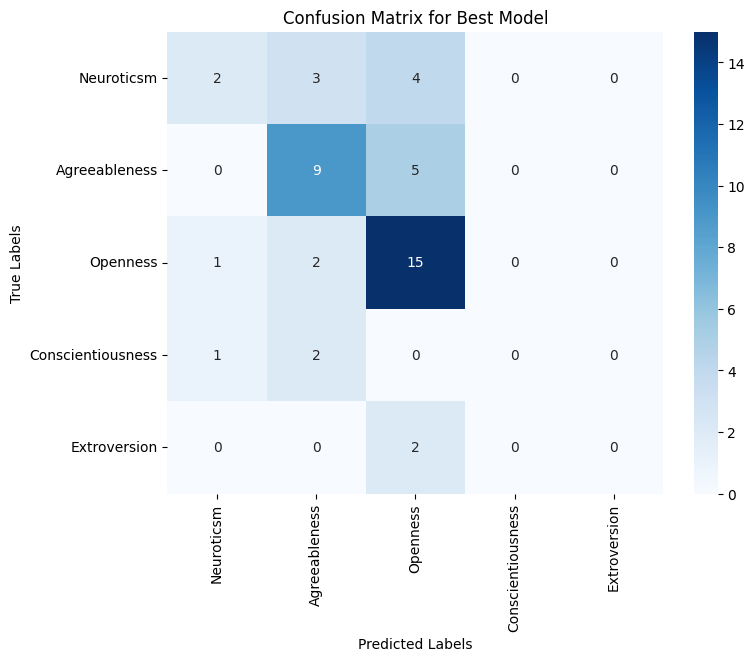


Classification Report for Best Model:
                   precision    recall  f1-score   support

       Neuroticsm     0.5000    0.2222    0.3077         9
    Agreeableness     0.5625    0.6429    0.6000        14
         Openness     0.5769    0.8333    0.6818        18
Conscientiousness     0.0000    0.0000    0.0000         3
     Extroversion     0.0000    0.0000    0.0000         2

         accuracy                         0.5652        46
        macro avg     0.3279    0.3397    0.3179        46
     weighted avg     0.4948    0.5652    0.5096        46

Best Model | Params: {'batch_size': 8, 'learning_rate': 3e-05} | Accuracy: 0.5652173913043478 | F1 Score: 0.5096077835208269

Results Table:
   learning_rate  batch_size  accuracy  f1_score
0        0.00002           8  0.413043  0.376011
1        0.00003           8  0.565217  0.509608
2        0.00004           8  0.456522  0.404480
3        0.00005           8  0.500000  0.427496
4        0.00002          16  0.543478  0

In [ ]:
# Suppress UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Define test_labels for evaluation
test_labels = test_data['label'].tolist()
model_name = "indobenchmark/indobert-base-p1"

# Initialize variables for best model
best_accuracy_indobert_scenario1 = 0
best_f1_indobert_scenario1 = 0
best_model_indobert_scenario1 = None
best_params_indobert_scenario1 = None

# Create a list to store results
results = []

# Grid Hyperparameters
param_grid = {
    'learning_rate': [2e-5, 3e-5, 4e-5, 5e-5],
    'batch_size': [8, 16]
}

# Loop parameter grid
for params in ParameterGrid(param_grid):
    print(f"Parameters: {params}")

    # Initialize model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=len(np.unique(test_labels))
    )

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"./results/{model_name}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=params['learning_rate'],
        per_device_train_batch_size=params['batch_size'],
        per_device_eval_batch_size=params['batch_size'],
        num_train_epochs=15,
        weight_decay=0.01,
        logging_dir=f"./logs/{model_name}",
        logging_steps=100,
        save_total_limit=2,
        fp16=True,
        report_to="none",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        logging_first_step=True,
        gradient_accumulation_steps=1
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=lambda p: {
            "accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1)),
            "precision": precision_recall_fscore_support(p.label_ids, np.argmax(p.predictions, axis=1), average='weighted')[0],
            "recall": precision_recall_fscore_support(p.label_ids, np.argmax(p.predictions, axis=1), average='weighted')[1],
            "f1": precision_recall_fscore_support(p.label_ids, np.argmax(p.predictions, axis=1), average='weighted')[2]
        }
    )

    # Train model
    trainer.train()

    # Evaluate model
    predictions = trainer.predict(test_dataset)
    predicted_labels = np.argmax(predictions.predictions, axis=1)

    accuracy = accuracy_score(test_labels, predicted_labels)
    f1 = precision_recall_fscore_support(test_labels, predicted_labels, average='weighted')[2]

    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"\nClassification Report for Params: {params}")
    print(classification_report(test_labels, predicted_labels, target_names=list(label_mapping.keys()), digits=4))

    # Store results
    results.append({
        'learning_rate': params['learning_rate'],
        'batch_size': params['batch_size'],
        'accuracy': accuracy,
        'f1_score': f1
    })

    # Update best model based on accuracy and F1 score
    if accuracy > best_accuracy_indobert_scenario1:
        best_accuracy_indobert_scenario1 = accuracy
        best_f1_indobert_scenario1 = f1
        best_model_indobert_scenario1 = model
        best_params_indobert_scenario1 = params
        best_predicted_labels_indobert_scenario1 = predicted_labels

# Confusion Matrix and Evaluation of Best Model
cm = confusion_matrix(test_labels, best_predicted_labels_indobert_scenario1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title("Confusion Matrix for Best Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print("\nClassification Report for Best Model:")
print(classification_report(test_labels, best_predicted_labels_indobert_scenario1, target_names=list(label_mapping.keys()), digits=4))

print(f"Best Model | Params: {best_params_indobert_scenario1} | Accuracy: {best_accuracy_indobert_scenario1} | F1 Score: {best_f1_indobert_scenario1}")

# Create a DataFrame from results
results_indobert_scenario1 = pd.DataFrame(results)

# Display the results table
print("\nResults Table:")
print(results_indobert_scenario1)

# Skenario 2

In [ ]:
# Load dataset
file_path = '/content/drive/My Drive/Dataset TA/skenario_2_final.csv'
data = pd.read_csv(file_path)

In [ ]:
# Create a label mapping
label_mapping = {label: idx for idx, label in enumerate(data['label'].unique())}
data['label'] = data['label'].map(label_mapping)

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])

# Load the tokenizer for IndoBERT
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

# Prepare text data for tokenization
train_texts = train_data['processed_text'].tolist()
test_texts = test_data['processed_text'].tolist()

# Tokenization for IndoBERT
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

In [ ]:
# Create the TweetDataset class
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])  # This should now be an integer
        return item

# Create datasets
train_dataset = TweetDataset(train_encodings, train_data['label'].tolist())
test_dataset = TweetDataset(test_encodings, test_data['label'].tolist())

Parameters: {'batch_size': 8, 'learning_rate': 2e-05}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-d9308d68c4eb>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.584400,1.388183,0.391304,0.153119,0.391304,0.220109
2,1.584400,1.409870,0.304348,0.092628,0.304348,0.142029
3,1.584400,1.374469,0.391304,0.153119,0.391304,0.220109
4,1.584400,1.409392,0.304348,0.144165,0.304348,0.195652
5,1.369600,1.455970,0.304348,0.092628,0.304348,0.142029
6,1.369600,1.451915,0.304348,0.201672,0.304348,0.231840
7,1.369600,1.624814,0.239130,0.260322,0.239130,0.211531
8,1.369600,1.595321,0.391304,0.391304,0.391304,0.349206
9,1.105100,1.648379,0.391304,0.335135,0.391304,0.345344
10,1.105100,1.710128,0.413043,0.357860,0.413043,0.380607


Accuracy: 0.41304347826086957
F1 Score: 0.38060731538992404

Classification Report for Params: {'batch_size': 8, 'learning_rate': 2e-05}
                   precision    recall  f1-score   support

       Neuroticsm     0.1111    0.1111    0.1111         9
    Agreeableness     0.4615    0.4286    0.4444        14
         Openness     0.5000    0.6667    0.5714        18
Conscientiousness     0.0000    0.0000    0.0000         3
     Extroversion     0.0000    0.0000    0.0000         2

         accuracy                         0.4130        46
        macro avg     0.2145    0.2413    0.2254        46
     weighted avg     0.3579    0.4130    0.3806        46

Parameters: {'batch_size': 8, 'learning_rate': 3e-05}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-d9308d68c4eb>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.584400,1.376242,0.391304,0.153119,0.391304,0.220109
2,1.584400,1.397291,0.304348,0.092628,0.304348,0.142029
3,1.584400,1.370860,0.391304,0.153119,0.391304,0.220109
4,1.584400,1.388173,0.391304,0.153119,0.391304,0.220109
5,1.376600,1.380350,0.456522,0.314010,0.456522,0.371337
6,1.376600,1.413861,0.500000,0.445652,0.500000,0.456914
7,1.376600,1.648761,0.347826,0.335545,0.347826,0.329529
8,1.376600,1.694196,0.434783,0.383757,0.434783,0.405512
9,0.838600,2.057745,0.391304,0.324939,0.391304,0.329255
10,0.838600,2.122137,0.369565,0.242095,0.369565,0.285068


Accuracy: 0.5
F1 Score: 0.45691435218845433

Classification Report for Params: {'batch_size': 8, 'learning_rate': 3e-05}
                   precision    recall  f1-score   support

       Neuroticsm     0.5000    0.3333    0.4000         9
    Agreeableness     0.5000    0.4286    0.4615        14
         Openness     0.5000    0.7778    0.6087        18
Conscientiousness     0.0000    0.0000    0.0000         3
     Extroversion     0.0000    0.0000    0.0000         2

         accuracy                         0.5000        46
        macro avg     0.3000    0.3079    0.2940        46
     weighted avg     0.4457    0.5000    0.4569        46

Parameters: {'batch_size': 8, 'learning_rate': 4e-05}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-d9308d68c4eb>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.584400,1.370850,0.391304,0.153119,0.391304,0.220109
2,1.584400,1.435717,0.304348,0.092628,0.304348,0.142029
3,1.584400,1.372304,0.391304,0.153119,0.391304,0.220109
4,1.584400,1.398703,0.391304,0.153119,0.391304,0.220109
5,1.389300,1.406802,0.456522,0.310955,0.456522,0.357860
6,1.389300,1.567255,0.413043,0.271511,0.413043,0.320356
7,1.389300,1.812205,0.260870,0.248436,0.260870,0.245016
8,1.389300,1.769309,0.391304,0.346014,0.391304,0.347081
9,0.755000,2.779932,0.282609,0.204969,0.282609,0.235350
10,0.755000,2.951193,0.347826,0.234329,0.347826,0.275264


Accuracy: 0.45652173913043476
F1 Score: 0.35785953177257523

Classification Report for Params: {'batch_size': 8, 'learning_rate': 4e-05}
                   precision    recall  f1-score   support

       Neuroticsm     0.0000    0.0000    0.0000         9
    Agreeableness     0.4167    0.3571    0.3846        14
         Openness     0.4706    0.8889    0.6154        18
Conscientiousness     0.0000    0.0000    0.0000         3
     Extroversion     0.0000    0.0000    0.0000         2

         accuracy                         0.4565        46
        macro avg     0.1775    0.2492    0.2000        46
     weighted avg     0.3110    0.4565    0.3579        46

Parameters: {'batch_size': 8, 'learning_rate': 5e-05}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-d9308d68c4eb>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.584400,1.369629,0.391304,0.153119,0.391304,0.220109
2,1.584400,1.407375,0.391304,0.303360,0.391304,0.252630
3,1.584400,1.378471,0.391304,0.153119,0.391304,0.220109
4,1.584400,1.379756,0.391304,0.153119,0.391304,0.220109
5,1.397800,1.387685,0.282609,0.201932,0.282609,0.205590
6,1.397800,1.427310,0.347826,0.304912,0.347826,0.324582
7,1.397800,1.652054,0.369565,0.239314,0.369565,0.288278
8,1.397800,2.059629,0.369565,0.245543,0.369565,0.294115
9,0.924200,2.383422,0.391304,0.263939,0.391304,0.301839
10,0.924200,2.517222,0.347826,0.243241,0.347826,0.285322


Accuracy: 0.391304347826087
F1 Score: 0.22010869565217392

Classification Report for Params: {'batch_size': 8, 'learning_rate': 5e-05}
                   precision    recall  f1-score   support

       Neuroticsm     0.0000    0.0000    0.0000         9
    Agreeableness     0.0000    0.0000    0.0000        14
         Openness     0.3913    1.0000    0.5625        18
Conscientiousness     0.0000    0.0000    0.0000         3
     Extroversion     0.0000    0.0000    0.0000         2

         accuracy                         0.3913        46
        macro avg     0.0783    0.2000    0.1125        46
     weighted avg     0.1531    0.3913    0.2201        46

Parameters: {'batch_size': 16, 'learning_rate': 2e-05}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-d9308d68c4eb>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.669700,1.413744,0.391304,0.153119,0.391304,0.220109
2,1.669700,1.420559,0.304348,0.092628,0.304348,0.142029
3,1.669700,1.365096,0.391304,0.156522,0.391304,0.223602
4,1.669700,1.343941,0.543478,0.377017,0.543478,0.443138
5,1.669700,1.397907,0.326087,0.251302,0.326087,0.275292
6,1.669700,1.387101,0.413043,0.359780,0.413043,0.379954
7,1.669700,1.412067,0.413043,0.358970,0.413043,0.381942
8,1.669700,1.581798,0.282609,0.267935,0.282609,0.250761
9,1.212700,1.623206,0.239130,0.200256,0.239130,0.210495
10,1.212700,1.515806,0.413043,0.344633,0.413043,0.371071


Accuracy: 0.5434782608695652
F1 Score: 0.4431380740652323

Classification Report for Params: {'batch_size': 16, 'learning_rate': 2e-05}
                   precision    recall  f1-score   support

       Neuroticsm     0.0000    0.0000    0.0000         9
    Agreeableness     0.5294    0.6429    0.5806        14
         Openness     0.5517    0.8889    0.6809        18
Conscientiousness     0.0000    0.0000    0.0000         3
     Extroversion     0.0000    0.0000    0.0000         2

         accuracy                         0.5435        46
        macro avg     0.2162    0.3063    0.2523        46
     weighted avg     0.3770    0.5435    0.4431        46

Parameters: {'batch_size': 16, 'learning_rate': 3e-05}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-d9308d68c4eb>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.669700,1.418998,0.391304,0.153119,0.391304,0.220109
2,1.669700,1.416196,0.304348,0.092628,0.304348,0.142029
3,1.669700,1.370913,0.391304,0.153119,0.391304,0.220109
4,1.669700,1.357220,0.478261,0.364734,0.478261,0.388178
5,1.669700,1.388704,0.369565,0.275362,0.369565,0.307529
6,1.669700,1.444209,0.304348,0.273551,0.304348,0.283344
7,1.669700,1.638402,0.304348,0.316890,0.304348,0.278938
8,1.669700,1.825482,0.282609,0.331522,0.282609,0.217681
9,1.192100,1.596107,0.304348,0.277671,0.304348,0.276918
10,1.192100,1.563527,0.456522,0.332531,0.456522,0.382844


Accuracy: 0.4782608695652174
F1 Score: 0.38817798458630215

Classification Report for Params: {'batch_size': 16, 'learning_rate': 3e-05}
                   precision    recall  f1-score   support

       Neuroticsm     0.0000    0.0000    0.0000         9
    Agreeableness     0.5556    0.3571    0.4348        14
         Openness     0.5000    0.9444    0.6538        18
Conscientiousness     0.0000    0.0000    0.0000         3
     Extroversion     0.0000    0.0000    0.0000         2

         accuracy                         0.4783        46
        macro avg     0.2111    0.2603    0.2177        46
     weighted avg     0.3647    0.4783    0.3882        46

Parameters: {'batch_size': 16, 'learning_rate': 4e-05}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-d9308d68c4eb>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.669700,1.396548,0.391304,0.153119,0.391304,0.220109
2,1.669700,1.397185,0.304348,0.092628,0.304348,0.142029
3,1.669700,1.366519,0.391304,0.153119,0.391304,0.220109
4,1.669700,1.384904,0.391304,0.201379,0.391304,0.253448
5,1.669700,1.435122,0.239130,0.154348,0.239130,0.165466
6,1.669700,1.437426,0.391304,0.305694,0.391304,0.326555
7,1.669700,1.522084,0.391304,0.352070,0.391304,0.341200
8,1.669700,1.899097,0.326087,0.325146,0.326087,0.275597
9,1.130200,1.659835,0.500000,0.347063,0.500000,0.409486
10,1.130200,1.729579,0.391304,0.355860,0.391304,0.370730


Accuracy: 0.5
F1 Score: 0.4094861660079051

Classification Report for Params: {'batch_size': 16, 'learning_rate': 4e-05}
                   precision    recall  f1-score   support

       Neuroticsm     0.0000    0.0000    0.0000         9
    Agreeableness     0.4737    0.6429    0.5455        14
         Openness     0.5185    0.7778    0.6222        18
Conscientiousness     0.0000    0.0000    0.0000         3
     Extroversion     0.0000    0.0000    0.0000         2

         accuracy                         0.5000        46
        macro avg     0.1984    0.2841    0.2335        46
     weighted avg     0.3471    0.5000    0.4095        46

Parameters: {'batch_size': 16, 'learning_rate': 5e-05}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-d9308d68c4eb>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.669700,1.380042,0.391304,0.153119,0.391304,0.220109
2,1.669700,1.389468,0.304348,0.092628,0.304348,0.142029
3,1.669700,1.368334,0.391304,0.156522,0.391304,0.223602
4,1.669700,1.419763,0.347826,0.152704,0.347826,0.212233
5,1.669700,1.507515,0.282609,0.087923,0.282609,0.134119
6,1.669700,1.430377,0.391304,0.327759,0.391304,0.342556
7,1.669700,1.447420,0.478261,0.445702,0.478261,0.410688
8,1.669700,1.641808,0.456522,0.456522,0.456522,0.430118
9,1.129000,1.692469,0.413043,0.308374,0.413043,0.344115
10,1.129000,1.834820,0.434783,0.312709,0.434783,0.358124


Accuracy: 0.4782608695652174
F1 Score: 0.41068784493202315

Classification Report for Params: {'batch_size': 16, 'learning_rate': 5e-05}
                   precision    recall  f1-score   support

       Neuroticsm     0.3750    0.3333    0.3529         9
    Agreeableness     0.6000    0.2143    0.3158        14
         Openness     0.4848    0.8889    0.6275        18
Conscientiousness     0.0000    0.0000    0.0000         3
     Extroversion     0.0000    0.0000    0.0000         2

         accuracy                         0.4783        46
        macro avg     0.2920    0.2873    0.2592        46
     weighted avg     0.4457    0.4783    0.4107        46



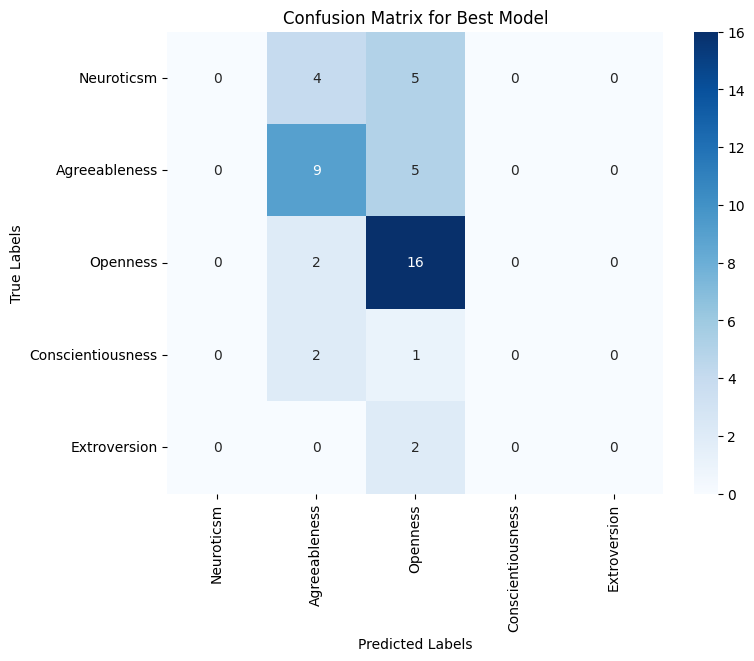


Classification Report for Best Model:
                   precision    recall  f1-score   support

       Neuroticsm     0.0000    0.0000    0.0000         9
    Agreeableness     0.5294    0.6429    0.5806        14
         Openness     0.5517    0.8889    0.6809        18
Conscientiousness     0.0000    0.0000    0.0000         3
     Extroversion     0.0000    0.0000    0.0000         2

         accuracy                         0.5435        46
        macro avg     0.2162    0.3063    0.2523        46
     weighted avg     0.3770    0.5435    0.4431        46

Best Model | Params: {'batch_size': 16, 'learning_rate': 2e-05} | Accuracy: 0.5434782608695652 | F1 Score: 0.4431380740652323

Results Table:
   learning_rate  batch_size  accuracy  f1_score
0        0.00002           8  0.413043  0.380607
1        0.00003           8  0.500000  0.456914
2        0.00004           8  0.456522  0.357860
3        0.00005           8  0.391304  0.220109
4        0.00002          16  0.543478  

In [ ]:
# Suppress UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Define test_labels for evaluation
test_labels = test_data['label'].tolist()
model_name = "indobenchmark/indobert-base-p1"

# Initialize variables for best model
best_accuracy_indobert_scenario2 = 0
best_f1_indobert_scenario2 = 0
best_model_indobert_scenario2 = None
best_params_indobert_scenario2 = None

# Create a list to store results
results = []

# Grid Hyperparameters
param_grid = {
    'learning_rate': [2e-5, 3e-5, 4e-5, 5e-5],
    'batch_size': [8, 16]
}

# Loop parameter grid
for params in ParameterGrid(param_grid):
    print(f"Parameters: {params}")

    # Initialize model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=len(np.unique(test_labels))
    )

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"./results/{model_name}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=params['learning_rate'],
        per_device_train_batch_size=params['batch_size'],
        per_device_eval_batch_size=params['batch_size'],
        num_train_epochs=15,
        weight_decay=0.01,
        logging_dir=f"./logs/{model_name}",
        logging_steps=100,
        save_total_limit=2,
        fp16=True,
        report_to="none",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        logging_first_step=True,
        gradient_accumulation_steps=1
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=lambda p: {
            "accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1)),
            "precision": precision_recall_fscore_support(p.label_ids, np.argmax(p.predictions, axis=1), average='weighted')[0],
            "recall": precision_recall_fscore_support(p.label_ids, np.argmax(p.predictions, axis=1), average='weighted')[1],
            "f1": precision_recall_fscore_support(p.label_ids, np.argmax(p.predictions, axis=1), average='weighted')[2]
        }
    )

    # Train model
    trainer.train()

    # Evaluate model
    predictions = trainer.predict(test_dataset)
    predicted_labels = np.argmax(predictions.predictions, axis=1)

    accuracy = accuracy_score(test_labels, predicted_labels)
    f1 = precision_recall_fscore_support(test_labels, predicted_labels, average='weighted')[2]

    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"\nClassification Report for Params: {params}")
    print(classification_report(test_labels, predicted_labels, target_names=list(label_mapping.keys()), digits=4))

    # Store results
    results.append({
        'learning_rate': params['learning_rate'],
        'batch_size': params['batch_size'],
        'accuracy': accuracy,
        'f1_score': f1
    })

    # Update best model based on accuracy and F1 score
    if accuracy > best_accuracy_indobert_scenario2:
        best_accuracy_indobert_scenario2 = accuracy
        best_f1_indobert_scenario2 = f1
        best_model_indobert_scenario2 = model
        best_params_indobert_scenario2 = params
        best_predicted_labels_indobert_scenario2 = predicted_labels

# Confusion Matrix and Evaluation of Best Model
cm = confusion_matrix(test_labels, best_predicted_labels_indobert_scenario2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title("Confusion Matrix for Best Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print("\nClassification Report for Best Model:")
print(classification_report(test_labels, best_predicted_labels_indobert_scenario2, target_names=list(label_mapping.keys()), digits=4))

print(f"Best Model | Params: {best_params_indobert_scenario2} | Accuracy: {best_accuracy_indobert_scenario2} | F1 Score: {best_f1_indobert_scenario2}")

# Create a DataFrame from results
results_indobert_scenario2 = pd.DataFrame(results)

# Display the results table
print("\nResults Table:")
print(results_indobert_scenario2)
